# Chapter 4: DDI 모델 학습 실행하기

1. **데이터 전처리**
    - 사용할 DDI 데이터셋을 확인하고, 모델에 적합한 형태로 데이터 변환
---
2. **DDI 모델 구조 파악**
    - SSI-DDI 모델의 각 부분을 살펴보고 어떤 기능을 수행하는지 파악
---
3. **모델 학습 실행하기**
    - SSI-DDI 모델을 사용해서 모델 학습 진행
---
4. **모델 Test하고 성능 저장하기**
    - 모델을 테스트하고 최적 성능 저장

In [ ]:
# # 셀 실행 후 Kernel Restart
# !pip install tabulate

In [1]:
import warnings
from rdkit import RDLogger

warnings.simplefilter(action='ignore', category=FutureWarning)
RDLogger.DisableLog('rdApp.*')

In [2]:
import os
import math
import time
import rdkit
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from sklearn import metrics
from torch import nn, optim
from tabulate import tabulate
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.nn.modules.container import ModuleList
from torch_geometric.nn import (GATConv,
                                SAGPooling,
                                LayerNorm,
                                global_add_pool)
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader, Batch

print(rdkit.__version__)

2024.03.5


## 1) 데이터 전처리

본 튜토리얼 코드에서 사용할 DrugBank 데이터셋은 86가지의 상호작용 타입을 가진 약물 쌍 데이터셋이다.   

각 약물은 SMILES 문자열로 표현되어있다.   

총 191,808개의 약물 쌍이 있고, 1,706가지의 약물이 포함되어있다.   

DrugBank 이외에 많이 사용되는 DDI 데이터셋으로는 TWOSIDES, KEGG, SIDER, OFFSIDES, BIOSNAP이 있다.    

출처 : https://go.drugbank.com/   

### 데이터 불러오기

DrugBank 폴더 안의 데이터를 불러오자. 

In [4]:
train = pd.read_csv('DrugBank/train.csv')
valid = pd.read_csv('DrugBank/valid.csv')
test = pd.read_csv('DrugBank/test.csv')

train의 상위 10개의 데이터셋을 확인하면, 하나의 데이터에 약물 2개와 하나의 Y 라벨이 있는 것을 확인할 수 있다.   

각 약물은 Drug ID와 SMILES 문자열로 표시되어있고, Y 라벨은 상호작용 타입을 나타낸다. 

> **Tip**: 현재 사용하고있는 DrugBank 데이터셋은 상호작용 타입이  1부터 86까지로 라벨링 되어있다.    
하지만 데이터셋에 따라 0부터 라벨링을 시작할 수 있으므로 label description을 잘 읽어보자!

In [5]:
train.head(10)

,Drug1_ID,Drug1,Drug2_ID,Drug2,Y
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
1,DB09536,O=[Ti]=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
2,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
3,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
4,DB11630,OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)...,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
5,DB06261,[H]N([H])CC(=O)CCC(=O)OCCCCCC,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
6,DB01878,O=C(C1=CC=CC=C1)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
7,DB00140,CC1=C(C)C=C2N(C[C@H](O)[C@H](O)[C@H](O)CO)C3=N...,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
8,DB00821,CC(C(O)=O)C1=CC2=C(C=C1)C1=C(N2)C=CC(Cl)=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
9,DB01116,O=C1N(CC2=CC=CC=C2)C2C[S+]3CCCC3C2N1CC1=CC=CC=C1,DB06148,CN1CCN2C(C1)C1=CC=CC=C1CC1=CC=CC=C21,2


데이터셋을 본격적으로 사용하기 전에, RDKit 버전에 따라 처리되지 않는 SMILES 문자열이 있다.   

전처리 과정에서 그러한 문자열을 제거해야한다.

remove_smiles.py 파일에 RDKit 버전에 맞지 않는 데이터를 제거하는 코드가 구현되어 있으므로 한번 사용해보자!

해당 파일을 실행하면 기존 데이터 폴더 안에 clean_smi라는 이름의 폴더가 생성되고, 그 안에 처리된 train, valid, test 파일이 생성된다.   

또한 전처리를 위한 모든 약물 쌍이 들어있는 파일, 약물 ID와 SMILES 문자열이 들어있는 파일이 utils 폴더 내에 생성된다.   

> **Tip**: ! python remove_smiles.py [train, valid, test 파일이 들어있는 폴더]   
코드를 실행하면 버전에 맞지 않는 데이터가 제거된 train, valid, test파일은 기존 폴더 안의 clean_smi 폴더 안에 들어있다.

In [6]:
! python remove_smiles.py DrugBank utils

Processing folder: DrugBank
Read train: 134265, valid: 19181, test: 38362
Combined total records: 191808
100%|█████████████████████████████████| 191808/191808 [00:28<00:00, 6698.34it/s]
Removed invalid SMILES: 10
Unique drugs: 1705
Cleaned dataset saved to 'DrugBank/clean_smi'
all_pairs.csv and all_smiles.csv saved to 'utils'


SSI-DDI 모델에 넣기 위해 해당 모델의 github에서 수행한 데이터 전처리 과정을 따라갈 것이다.    

우선 약물 1쌍(2개의 약물)의 Drug ID와 상호작용 타입으로 구성된 데이터를 하나의 튜플로 묶자.  
  
여기서 h는 head(첫번째 약물), t는 tail(두번째 약물), r은 relation type(상호작용 타입)을 뜻한다.    

In [7]:
clean_train = pd.read_csv('DrugBank/clean_smi/train.csv')
clean_valid = pd.read_csv('DrugBank/clean_smi/valid.csv')
clean_test = pd.read_csv('DrugBank/clean_smi/test.csv')

In [8]:
train_tup = [(h, t, r) for h, t, r in zip(clean_train['Drug1_ID'], clean_train['Drug2_ID'], clean_train['Y'])]
valid_tup = [(h, t, r) for h, t, r in zip(clean_valid['Drug1_ID'], clean_valid['Drug2_ID'], clean_valid['Y'])]
test_tup = [(h, t, r) for h, t, r in zip(clean_test['Drug1_ID'], clean_test['Drug2_ID'], clean_test['Y'])]

In [9]:
train_len = len(train_tup)
valid_len = len(valid_tup)
test_len = len(test_tup)
total_len = train_len + valid_len + test_len

print('train 데이터셋 크기 :', train_len)
print('valid 데이터셋 크기 :', valid_len)
print('test 데이터셋 크기 :', test_len)

print('train : valid : test 비율 : ', train_len/total_len, ':', valid_len/total_len, ':', test_len/total_len)

train 데이터셋 크기 : 134256
valid 데이터셋 크기 : 19180
test 데이터셋 크기 : 38362
train : valid : test 비율 :  0.6999864440713668 : 0.10000104276374101 : 0.20001251316489224


데이터를 전처리 하기 위해 RDKit 등의 도구를 활용해 분자 구조와 관련된 특성을 계산하는 부분은 본 튜토리얼 코드에서는 설명을 생략한다. 

In [10]:
import itertools
from collections import defaultdict
from operator import neg
import random
import math
import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from rdkit import Chem
import pandas as pd
import numpy as np

from MAIL.utils.data_preprocessing import (
    MOL_EDGE_LIST_FEAT_MTX, ALL_DRUG_IDS, ALL_TRUE_H_WITH_TR, ALL_TRUE_T_WITH_HR,
    ALL_TAIL_PER_HEAD, ALL_HEAD_PER_TAIL
)

/home/seoziro7777/DDITutorials/utils/data_preprocessing.py:105: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return undirected_edge_list.T, features


### Negative Sample 만들기

모델에서 train, validation, test를 위해 negative sample을 생성해야한다.    

데이터에는 한 쌍의 약물을 동시에 복용했을 때 상호작용이 있는 경우만 들어있으므로, 학습을 위해 `상호작용이 없는 약물 쌍을 전처리 과정에서 생성`해야한다.    

본 모델에서는 collate_fn 함수를 사용하여 positive sample과 negative sample을 생성하고, PyTorch Geometric의 Batch 객체로 데이터를 변환한다. 

collate_fn 함수를 살펴보기 전에, 우선 DrugDataset 클래스 내에서 사용되는 __create_graph_data, __corrupt_ent, __corrupt_head, __corrupt_tail, __normal_batch에 대해서 살펴보자. 

#### 1. __create_graph_data   

약물의 ID를 입력받아 그래프 데이터를 생성함.    

In [11]:
def __create_graph_data(self, id):
        edge_index = MOL_EDGE_LIST_FEAT_MTX[id][0]
        features = MOL_EDGE_LIST_FEAT_MTX[id][1]

        return Data(x=features, edge_index=edge_index)

#### 2. __corrupt_ent

Negative Sampling을 위해 head와 tail 쌍과 관계가 없는 무작위 다른 약물을 샘플링함.      
무작위로 선택한 약물이 관계가 있을 수 있으므로 그런 약물은 제외하고 Negative Sample을 생성   

`np.random.choice(self.drug_ids, ...)` : 전체 약물 ID 중에서 무작위로 후보를 선택   

`other_ent_with_r_dict` : 관계 r에서 other_ent와 관계가 있는 약물 목록을 저장한 딕셔너리   

`np.isin(candidates, ..., invert=True)` : 후보 약물 중에서 이미 other_ent와 관계가 있는 약물을 제외   


In [12]:
def __corrupt_ent(self, other_ent, r, other_ent_with_r_dict, max_num=1):
    corrupted_ents = []
    current_size = 0
    while current_size < max_num:
        candidates = np.random.choice(self.drug_ids, (max_num - current_size) * 2)
        mask = np.isin(candidates, other_ent_with_r_dict[(other_ent, r)], assume_unique=True, invert=True)
        corrupted_ents.append(candidates[mask])
        current_size += len(corrupted_ents[-1])
    
    if corrupted_ents != []:
        corrupted_ents = np.concatenate(corrupted_ents)

    return np.asarray(corrupted_ents[:max_num])

#### 3. __corrupt_head & __corrupt_tail

특정 관계 r에 대해 head 또는 tail의 negative sample을 생성함.   
__corrupt_ent를 호출하여 tail 또는 head와 관계가 없는 약물을 샘플링   

`__corrupt_head` 일 경우 tail과 relation type은 고정하고 head의 약물을 무작위 다른 약물로 변환 (head, tail, relation)   -> (random other drug, tail, relation)    
`__corrupt_tail` 일 경우 head와 realation type은 고정하고 tail의 약물을 무작위 다른 약물로 변환 (head, tail, relation) -> (head, random other drug, relation)

In [13]:
def __corrupt_head(self, t, r, n=1):
        return self.__corrupt_ent(t, r, ALL_TRUE_H_WITH_TR, n)

def __corrupt_tail(self, h, r, n=1):
        return self.__corrupt_ent(h, r, ALL_TRUE_T_WITH_HR, n)

#### 4. __normal_batch

Negative head와 negative tail의 개수를 동적으로 결정하고, 위의 __corrupt_head, __corrupt_tail을 호출하여 샘플링   
조정할 수 있는 neg_size에 따라 Positive Sample과 Negative Sample의 비율을 맞춰 Negative Sample을 생성

In [14]:
def __normal_batch(self, h, t, r, neg_size):
    neg_size_h = 0
    neg_size_t = 0
    prob = ALL_TAIL_PER_HEAD[r] / (ALL_TAIL_PER_HEAD[r] + ALL_HEAD_PER_TAIL[r])
    for i in range(neg_size):
        if random.random() < prob:
            neg_size_h += 1
        else:
            neg_size_t +=1
    
    return (self.__corrupt_head(t, r, neg_size_h),
            self.__corrupt_tail(h, r, neg_size_t))  

#### collate_fn 함수

1. Positive Sample 생성    

- 각 약물 쌍 (h, t)과 상호작용 타입 r을 불러옴
- 약물 head(Drug1)와 tail(Drug2)의 정보를 그래프로 변환하기 위해 `__create_graph_data` 함수를 호출하여 PyTorch Geometric의 Data 객체로 변환  
- 변환된 그래프와 상호작용 타입 r을 positive sample 리스트에 추가 

2. Negative Sample 생성

- `__normal_batch` 함수를 사용하여 약물 쌍 (h, t, r)에 대해 negative sample을 생성 
- head 또는 tail 중 하나를 다른 약물로 무작위 변경하면서, 상호작용 타입 r은 유지
- 변경된 약물 정보를 다시 `__create_graph_data`로 그래프로 변환하여 negative sample 리스트에 추가

3. Batch 생성

- Positive와 Negative Sample 데이터를 PyTorch Geometric의 `Batch.from_data_list`로 묶어 미니배치 단위로 결합
- Positive와 Negative 데이터를 튜플 형태 (positive_batch, negative_batch)로 반환하여, 모델이 한 번에 두 데이터를 모두 학습할 수 있도록 준비

In [15]:
def collate_fn(self, batch):

        pos_rels = []
        pos_h_samples = []
        pos_t_samples = []
        neg_rels = []
        neg_h_samples = []
        neg_t_samples = []

        for h, t, r in batch:
            pos_rels.append(r)
            h_data = self.__create_graph_data(h)
            t_data = self.__create_graph_data(t)
            pos_h_samples.append(h_data)
            pos_t_samples.append(t_data)

            neg_heads, neg_tails = self.__normal_batch(h, t, r, self.neg_ent)

            for neg_h in neg_heads:
                neg_rels.append(r)
                neg_h_samples.append(self.__create_graph_data(neg_h))
                neg_t_samples.append(t_data)

            for neg_t in neg_tails:
                neg_rels.append(r)
                neg_h_samples.append(h_data)
                neg_t_samples.append(self.__create_graph_data(neg_t))

        pos_h_samples = Batch.from_data_list(pos_h_samples)
        pos_t_samples = Batch.from_data_list(pos_t_samples)
        pos_rels = torch.LongTensor(pos_rels)
        pos_tri = (pos_h_samples, pos_t_samples, pos_rels)

        neg_h_samples = Batch.from_data_list(neg_h_samples)
        neg_t_samples = Batch.from_data_list(neg_t_samples)
        neg_rels = torch.LongTensor(neg_rels)
        neg_tri = (neg_h_samples, neg_t_samples, neg_rels)

        return pos_tri, neg_tri
            

전체 DrugDataset 클래스 코드는 다음과 같다. 

In [16]:
class DrugDataset(Dataset):
    def __init__(self, tri_list, ratio=1.0,  neg_ent=1, disjoint_split=True, shuffle=True):
        ''''disjoint_split: Consider whether entities should appear in one and only one split of the dataset
        ''' 
        self.neg_ent = neg_ent
        self.tri_list = []
        self.ratio = ratio

        for h, t, r, *_ in tri_list:
            if ((h in MOL_EDGE_LIST_FEAT_MTX) and (t in MOL_EDGE_LIST_FEAT_MTX)):
                self.tri_list.append((h, t, r))

        if disjoint_split:
            d1, d2, *_ = zip(*self.tri_list)
            self.drug_ids = np.array(list(set(d1 + d2)))
        else:
            self.drug_ids = ALL_DRUG_IDS

        self.drug_ids = np.array([id for id in self.drug_ids if id in MOL_EDGE_LIST_FEAT_MTX])
        
        if shuffle:
            random.shuffle(self.tri_list)
        limit = math.ceil(len(self.tri_list) * ratio)
        self.tri_list = self.tri_list[:limit]

    def __len__(self):
        return len(self.tri_list)
    
    def __getitem__(self, index):
        return self.tri_list[index]

    def collate_fn(self, batch):

        pos_rels = []
        pos_h_samples = []
        pos_t_samples = []
        neg_rels = []
        neg_h_samples = []
        neg_t_samples = []

        for h, t, r in batch:
            pos_rels.append(r)
            h_data = self.__create_graph_data(h)
            t_data = self.__create_graph_data(t)
            pos_h_samples.append(h_data)
            pos_t_samples.append(t_data)

            neg_heads, neg_tails = self.__normal_batch(h, t, r, self.neg_ent)

            for neg_h in neg_heads:
                neg_rels.append(r)
                neg_h_samples.append(self.__create_graph_data(neg_h))
                neg_t_samples.append(t_data)

            for neg_t in neg_tails:
                neg_rels.append(r)
                neg_h_samples.append(h_data)
                neg_t_samples.append(self.__create_graph_data(neg_t))

        pos_h_samples = Batch.from_data_list(pos_h_samples)
        pos_t_samples = Batch.from_data_list(pos_t_samples)
        pos_rels = torch.LongTensor(pos_rels)
        pos_tri = (pos_h_samples, pos_t_samples, pos_rels)

        neg_h_samples = Batch.from_data_list(neg_h_samples)
        neg_t_samples = Batch.from_data_list(neg_t_samples)
        neg_rels = torch.LongTensor(neg_rels)
        neg_tri = (neg_h_samples, neg_t_samples, neg_rels)

        return pos_tri, neg_tri
            
    def __create_graph_data(self, id):
        edge_index = MOL_EDGE_LIST_FEAT_MTX[id][0]
        features = MOL_EDGE_LIST_FEAT_MTX[id][1]

        return Data(x=features, edge_index=edge_index)

    def __corrupt_ent(self, other_ent, r, other_ent_with_r_dict, max_num=1):
        corrupted_ents = []
        current_size = 0
        while current_size < max_num:
            candidates = np.random.choice(self.drug_ids, (max_num - current_size) * 2)
            mask = np.isin(candidates, other_ent_with_r_dict[(other_ent, r)], assume_unique=True, invert=True)
            corrupted_ents.append(candidates[mask])
            current_size += len(corrupted_ents[-1])
        
        if corrupted_ents != []:
            corrupted_ents = np.concatenate(corrupted_ents)

        return np.asarray(corrupted_ents[:max_num])
        
    def __corrupt_head(self, t, r, n=1):
        return self.__corrupt_ent(t, r, ALL_TRUE_H_WITH_TR, n)

    def __corrupt_tail(self, h, r, n=1):
        return self.__corrupt_ent(h, r, ALL_TRUE_T_WITH_HR, n)
    
    def __normal_batch(self, h, t, r, neg_size):
        neg_size_h = 0
        neg_size_t = 0
        prob = ALL_TAIL_PER_HEAD[r] / (ALL_TAIL_PER_HEAD[r] + ALL_HEAD_PER_TAIL[r])
        for i in range(neg_size):
            if random.random() < prob:
                neg_size_h += 1
            else:
                neg_size_t +=1
        
        return (self.__corrupt_head(t, r, neg_size_h),
                self.__corrupt_tail(h, r, neg_size_t))  

Positive Sample의 비율을 조정하는 ratio와 각 Positive Sample 당 생성할 Negative Sample의 수를 조정하는 neg_ent를 각각 1로 설정하여 데이터를 직접 Negative Sampling 해보자. 

`ratio` : `1.0`이면 전체 Positive Sample 데이터를 사용   
`neg_ent` : `1.0`이면 Positive Sample과 Negative Sample의 비율이 1:1로 동일함

disjoint_split : 데이터셋을 나눌 때 약물이 train, valid, test 등 데이터셋의 split에서 겹치지 않게 포함될지 여부를 결정하게 함.   
shuffle : 데이터셋 내에서 데이터를 섞을지 여부를 결정하게 함.    

(본 튜토리얼 코드에서는 설명을 위해 둘 다 False로 설정한 후 진행하였음)

In [17]:
train_data = DrugDataset(train_tup, ratio = 1, neg_ent = 1, disjoint_split=False, shuffle=False)
valid_data = DrugDataset(valid_tup, ratio = 1, neg_ent = 1, disjoint_split=False, shuffle=False)
test_data = DrugDataset(test_tup, ratio = 1, neg_ent = 1, disjoint_split=False, shuffle=False)

실제 train.csv의 첫번째 데이터를 확인하면 다음과 같다.    

*DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C(=C\2)/C(CCC(O)=O)=C5C)C(C=C)=C4C)C2=CC=C([C@@H](C(=O)OC)[C@@]32C)C(=O)OC)=C1C,1,train*

(DB04571, DB00460) 약물 쌍이 1번 상호작용을 일으킨다는 데이터이다.  

* * *

train_data[0]의 경우 Positive Sample으로, 실제 상호작용을 나타내는 약물 쌍이다.   
반면, train_data[1]의 경우 Negative Sample로, 상호작용을 나타내지 않는 가짜 약물 쌍이다.    

In [18]:
print(train_data[0])
print(train_data[1])

('DB04571', 'DB00460', 1)
('DB09536', 'DB00460', 1)


이후 DrugDataset에서 정의한 약물 쌍 데이터를 한번에 batch_size 만큼 가져와 묶는 과정을 거친다.    
이때 Pytorch의 기본 DataLoader를 확장한 DrugDataLoader를 사용한다. 

In [19]:
class DrugDataLoader(DataLoader):
    def __init__(self, data, **kwargs):
        super().__init__(data, collate_fn=data.collate_fn, **kwargs)

본 튜토리얼에서는 256개의 데이터를 하나의 배치로 묶어 사용하였다. 

In [20]:
train_data_loader = DrugDataLoader(train_data, batch_size = 256, shuffle = False)
valid_data_loader = DrugDataLoader(valid_data, batch_size = 256, shuffle = False)
test_data_loader = DrugDataLoader(test_data, batch_size = 256, shuffle = False)

하나의 배치를 확인해보면, 다음과 같이 구성되어있다.   

(Positive triples, Negative triples) = ((Drug1, Drug2, relation type), (Drug1, Drug2, relation type))

In [21]:
for i in train_data_loader:
    break
i

((DataBatch(x=[6151, 55], edge_index=[2, 13302], batch=[6151], ptr=[257]),
  DataBatch(x=[6415, 55], edge_index=[2, 14018], batch=[6415], ptr=[257]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
          3, 3, 3, 3, 3, 3, 3,

하나의 데이터 배치를 살펴보자. 

`DataBatch(x=[6151, 55], edge_index=[2, 13302], batch=[6151], ptr=[257])`

- x : 노드 특징 행렬, 위 예시의 경우 6151개의 노드가 각각 55개의 특징을 가짐.    
- edge_index : 그래프의 엣지 리스트. 위 예시의 경우 그래프가 13,302개의 엣지를 가짐.   
- batch : 여러 분자 그래프를 하나의 배치에 모아 놓은 것이므로 각 노드가 어떤 그래프에 속하는지 나타냄.    
- ptr : 그래프별 노드의 시작 인덱스를 나타냄. 그래프를 구분하는데 사용함.    

## 2) DDI 모델 구조 파악

본 튜토리얼 코드에서는 간단하면서도 좋은 성능을 나타내는 SSI-DDI 모델([논문](https://academic.oup.com/bib/article/22/6/bbab133/6265181), [GitHub](https://github.com/kanz76/SSI-DDI/tree/master))을 사용하여 DDI 데이터를 처리하는 모델 구조를 살펴볼 것이다.    

### SSI-DDI 모델 구조
<div style="text-align: center;">
    <img src="./model_fig.jpeg" alt="Description" width="1000px">
</div>

모델 구조를 자세히 살펴보자. 

모델 작동 흐름은 다음과 같다. 

1. 모델은 두 약물의 그래프 형태를 입력받는다. 

2. 각 `GAT` 층에서 각 층의 receptive field에 포함되는 substructure를 추출하기 위한 READOUT 작업이 수행된다. 

3. `co-attention` 층에서 각 substructure 간 상호작용의 중요도를 계산한다. 여기서 중요한 점은, 각 GAT 층에서 추출된 두 약물의 substructure들이 최종적으로 DDI 예측에 얼마나 기여하는지가 다르기 때문에,    
co-attention 층을 사용해 이러한 중요도를 각각 계산하는 것이다. 즉, 두 약물의 하위구조가 서로 상호작용할 때, 어떤 하위구조들이 더 중요한 역할을 하는지를 파악하고 이를 반영하는 방식이다.

4. 최종적으로 각 substructure의 중요도를 반영한 값으로 두 약물의 상호작용을 예측한다. 

- `GAT (Graph Attention Network)` : GNN의 한 종류로, 중요한 노드에 좀 더 집중하는 모델
- `Receptive Field` : GNN에서 층이 지날수록 더 넓은 범위의 노드에서부터 정보를 받는데, 이때 정보를 받는 범위
- `Substructure` : 전체 분자 구조에서의 작은 부분

> 이처럼 GAT와 co-attention 층을 조합해, 약물 간 상호작용 예측에서 각 하위구조의 중요도를 효율적으로 반영하는 것이 모델의 핵심이다!

#### `GAT (Graph Attention Network)`

In [22]:
class SSI_DDI_Block(nn.Module):
    def __init__(self, n_heads, in_features, head_out_feats, final_out_feats):
        super().__init__()
        self.n_heads = n_heads
        self.in_features = in_features
        self.out_features = head_out_feats
        self.conv = GATConv(in_features, head_out_feats, n_heads)
        self.readout = SAGPooling(n_heads * head_out_feats, min_score=-1)
    
    def forward(self, data):
        data.x = self.conv(data.x, data.edge_index)
        att_x, att_edge_index, att_edge_attr, att_batch, att_perm, att_scores= self.readout(data.x, data.edge_index, batch=data.batch)
        global_graph_emb = global_add_pool(att_x, att_batch)

        # data = max_pool_neighbor_x(data)
        return data, global_graph_emb

전체 모델 내에서 반복되어 실행되는 SSI_DDI_Block으로, GATConv와 SAGPooling을 사용하여 입력 그래프에서 정보를 추출하고, 글로벌 그래프 임베딩을 생성하고 있다.       
<div style="text-align: left;">
    <img src="./GNN.jpeg" alt="Description" width="500px">
</div>
이 블록은 반복적으로 실행되면서 그래프에서 점점 더 넓은 범위의 서브그래프를 탐색하고, 정보를 통합하여 더 풍부한 관계와 특징을 학습한다.    

SAGPooling : 중요한 노드만 남기고 불필요한 노드는 제거하여 그래프를 간소화하고, 더 중요한 노드 위주로 추출할 수 있게 하는 Pooling 기법

#### `CoAttentionLayer`

In [23]:
class CoAttentionLayer(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features
        self.w_q = nn.Parameter(torch.zeros(n_features, n_features//2))
        self.w_k = nn.Parameter(torch.zeros(n_features, n_features//2))
        self.bias = nn.Parameter(torch.zeros(n_features // 2))
        self.a = nn.Parameter(torch.zeros(n_features//2))

        nn.init.xavier_uniform_(self.w_q)
        nn.init.xavier_uniform_(self.w_k)
        nn.init.xavier_uniform_(self.bias.view(*self.bias.shape, -1))
        nn.init.xavier_uniform_(self.a.view(*self.a.shape, -1))
    
    def forward(self, receiver, attendant):
        keys = receiver @ self.w_k
        queries = attendant @ self.w_q
        # values = receiver @ self.w_v
        values = receiver

        e_activations = queries.unsqueeze(-3) + keys.unsqueeze(-2) + self.bias
        e_scores = torch.tanh(e_activations) @ self.a
        # e_scores = e_activations @ self.a
        attentions = e_scores

        return attentions

<div style="text-align: left;">
    <img src="./coattention.PNG" alt="Description" width="500px">
</div>

두 약물의 하위구조인 receiver와 attendant 간의 상호작용을 학습하여 하위구조들 간의 Attention Score를 얻는다.    
Block을 4번 실행시키면, 그림에서처럼 4개의 Substructure가 두 약물에서 나온다.    
이때 4개의 Substructure끼리 co-attention 계산을 하여 4*4 matrix 형태의 Attention Matrix도 얻을 수 있다. 

#### `최종 Score 계산`

In [24]:
class RESCAL(nn.Module):
    def __init__(self, n_rels, n_features):
        super().__init__()
        self.n_rels = n_rels
        self.n_features = n_features
        self.rel_emb = nn.Embedding(self.n_rels, n_features * n_features)
        nn.init.xavier_uniform_(self.rel_emb.weight)
    
    def forward(self, heads, tails, rels, alpha_scores):
        rels = self.rel_emb(rels)
        rels = F.normalize(rels, dim=-1)
        heads = F.normalize(heads, dim=-1)
        tails = F.normalize(tails, dim=-1)
        rels = rels.view(-1, self.n_features, self.n_features)

        scores = heads @ rels @ tails.transpose(-2, -1)

        if alpha_scores is not None:
          scores = alpha_scores * scores
        scores = scores.sum(dim=(-2, -1))
        return scores 
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.n_rels}, {self.rel_emb.weight.shape})"

최종적으로 통과되는 RESCAL(KGE) 레이어는 `relation type을 행렬`로 나타내어 반영해주고, 최종 score를 계산하는 레이어이다. 

이때 co-attention layer를 통해 얻은 중요한 하위구조가 강조된 attentions를 최종 score에 곱해주면서 계산된 가중치를 부여한다. 

head와 tail은 64차원 벡터로 입력되고, 1개의 벡터인 relation type은 64(kge_dim)*64(kge_dim) 행렬로 변환된다. 

최종 모델 출력은 head, rels, tails, 그리고 co-attention으로 구해진 가중치가 곱해져 계산된다. 

전체 SSI-DDI 모델 구조는 다음과 같다.    

In [25]:
class SSI_DDI(nn.Module):
    def __init__(self, in_features, hidd_dim, kge_dim, rel_total, heads_out_feat_params, blocks_params):
        super().__init__()
        self.in_features = in_features
        self.hidd_dim = hidd_dim
        self.rel_total = rel_total
        self.kge_dim = kge_dim
        self.n_blocks = len(blocks_params)
        
        self.initial_norm = LayerNorm(self.in_features)
        self.blocks = []
        self.net_norms = ModuleList()
        for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_params)):
            block = SSI_DDI_Block(n_heads, in_features, head_out_feats, final_out_feats=self.hidd_dim)
            self.add_module(f"block{i}", block)
            self.blocks.append(block)
            self.net_norms.append(LayerNorm(head_out_feats * n_heads))
            in_features = head_out_feats * n_heads
        
        self.co_attention = CoAttentionLayer(self.kge_dim)
        self.KGE = RESCAL(self.rel_total, self.kge_dim)

    def forward(self, triples, return_attention=False):
        h_data, t_data, rels = triples

        h_data.x = self.initial_norm(h_data.x, h_data.batch)
        t_data.x = self.initial_norm(t_data.x, t_data.batch)

        repr_h = []
        repr_t = []

        for i, block in enumerate(self.blocks):
            out1, out2 = block(h_data), block(t_data)

            h_data = out1[0]
            t_data = out2[0]
            r_h = out1[1]
            r_t = out2[1]

            repr_h.append(r_h)
            repr_t.append(r_t)

            h_data.x = F.elu(self.net_norms[i](h_data.x, h_data.batch))
            t_data.x = F.elu(self.net_norms[i](t_data.x, t_data.batch))
        
        repr_h = torch.stack(repr_h, dim=-2)
        repr_t = torch.stack(repr_t, dim=-2)

        kge_heads = repr_h
        kge_tails = repr_t

        attentions = self.co_attention(kge_heads, kge_tails)
        
        # RESCAL의 4x4 행렬과 숫자 합산된 스코어 반환
        scores_matrix, scores = self.KGE(kge_heads, kge_tails, rels, attentions)

        if return_attention:
            return scores_matrix, rels, scores
        return scores

#### Train 데이터의 첫번째 배치의 양성쌍을 이용해 Attention Matrix, 최종 Score가 계산되는 Matrix, Relation type matrix를 직접 살펴보자.    

원래의 코드에는 없지만 Matrix들을 반환할 수 있도록 return_attention 옵션을 추가하였다.    

또한 RESCAL 함수에서 attention matrix과 Score matrix, relation matrix를 출력할 수 있게 수정하였다. 

In [26]:
class RESCAL(nn.Module):
    def __init__(self, n_rels, n_features):
        super().__init__()
        self.n_rels = n_rels # rel_total = 87
        self.n_features = n_features # kge_dim = 64
        self.rel_emb = nn.Embedding(self.n_rels, n_features * n_features)
        nn.init.xavier_uniform_(self.rel_emb.weight)
    
    def forward(self, heads, tails, rels, alpha_scores):
        # 임베딩 및 정규화
        rels = self.rel_emb(rels)
        rels = F.normalize(rels, dim=-1)
        heads = F.normalize(heads, dim=-1)
        tails = F.normalize(tails, dim=-1)
        rels = rels.view(-1, self.n_features, self.n_features)
        final_rels = rels
        # 4x4 행렬 스코어 계산
        scores = heads @ rels @ tails.transpose(-2, -1)

        # alpha_scores(co-attention 결과) 적용
        if alpha_scores is not None:
            scores = alpha_scores * scores
        
        original_scores = scores.clone()

        # 스코어 합산하여 숫자 1개로 변환
        scores = scores.sum(dim=(-2, -1))
        return alpha_scores, original_scores, final_rels, scores 
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.n_rels}, {self.rel_emb.weight.shape})"

In [27]:
class SSI_DDI(nn.Module):
    def __init__(self, in_features, hidd_dim, kge_dim, rel_total, heads_out_feat_params, blocks_params):
        super().__init__()
        self.in_features = in_features
        self.hidd_dim = hidd_dim
        self.rel_total = rel_total
        self.kge_dim = kge_dim
        self.n_blocks = len(blocks_params)
        
        self.initial_norm = LayerNorm(self.in_features)
        self.blocks = []
        self.net_norms = ModuleList()
        for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_params)):
            block = SSI_DDI_Block(n_heads, in_features, head_out_feats, final_out_feats=self.hidd_dim)
            self.add_module(f"block{i}", block)
            self.blocks.append(block)
            self.net_norms.append(LayerNorm(head_out_feats * n_heads))
            in_features = head_out_feats * n_heads
        
        self.co_attention = CoAttentionLayer(self.kge_dim)
        self.KGE = RESCAL(self.rel_total, self.kge_dim)

    def forward(self, triples, return_attention=False):
        h_data, t_data, rels = triples

        h_data.x = self.initial_norm(h_data.x, h_data.batch)
        t_data.x = self.initial_norm(t_data.x, t_data.batch)

        repr_h = []
        repr_t = []

        for i, block in enumerate(self.blocks):
            out1, out2 = block(h_data), block(t_data)

            h_data = out1[0]
            t_data = out2[0]
            r_h = out1[1]
            r_t = out2[1]

            repr_h.append(r_h)
            repr_t.append(r_t)

            h_data.x = F.elu(self.net_norms[i](h_data.x, h_data.batch))
            t_data.x = F.elu(self.net_norms[i](t_data.x, t_data.batch))
        
        repr_h = torch.stack(repr_h, dim=-2)
        repr_t = torch.stack(repr_t, dim=-2)

        kge_heads = repr_h
        kge_tails = repr_t

        attentions = self.co_attention(kge_heads, kge_tails)
        
        # RESCAL의 4x4 행렬과 숫자 합산된 스코어 반환
        attention_matrix, original_scores, rels, scores = self.KGE(kge_heads, kge_tails, rels, attentions)

        if return_attention:
            return attention_matrix, original_scores, rels, scores
        return scores

In [28]:
# Hyperparameters
n_atom_feats = 55
n_atom_hid = 64
rel_total = 87
lr = 1e-2
weight_decay = 5e-4
n_epochs = 100
neg_samples = 1
batch_size = 1024
data_size_ratio = 1
kge_dim = 64

Attention Matrix, Score Matrix, Relation Matrix를 출력하기 위해 임시로 모델을 정의하였다.    

실제 학습을 위한 모델은 뒤에서 다시 정의할 예정이다.    

In [29]:
matrix_model = SSI_DDI(n_atom_feats, n_atom_hid, kge_dim, rel_total, heads_out_feat_params=[32, 32, 32, 32], blocks_params=[2, 2, 2, 2])
matrix_model

SSI_DDI(
  (initial_norm): LayerNorm(55, affine=True, mode=graph)
  (net_norms): ModuleList(
    (0-3): 4 x LayerNorm(64, affine=True, mode=graph)
  )
  (block0): SSI_DDI_Block(
    (conv): GATConv(55, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block1): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block2): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block3): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (co_attention): CoAttentionLayer()
  (KGE): RESCAL(87, torch.Size([87, 4096]))
)

In [30]:
matrix_model.eval()
for batch in train_data_loader:
    positive_triplet, negative_triplet = batch
    
    with torch.no_grad():
        attention_matrix, original_scores, rels, scores_positive = matrix_model(positive_triplet, return_attention=True)
    break

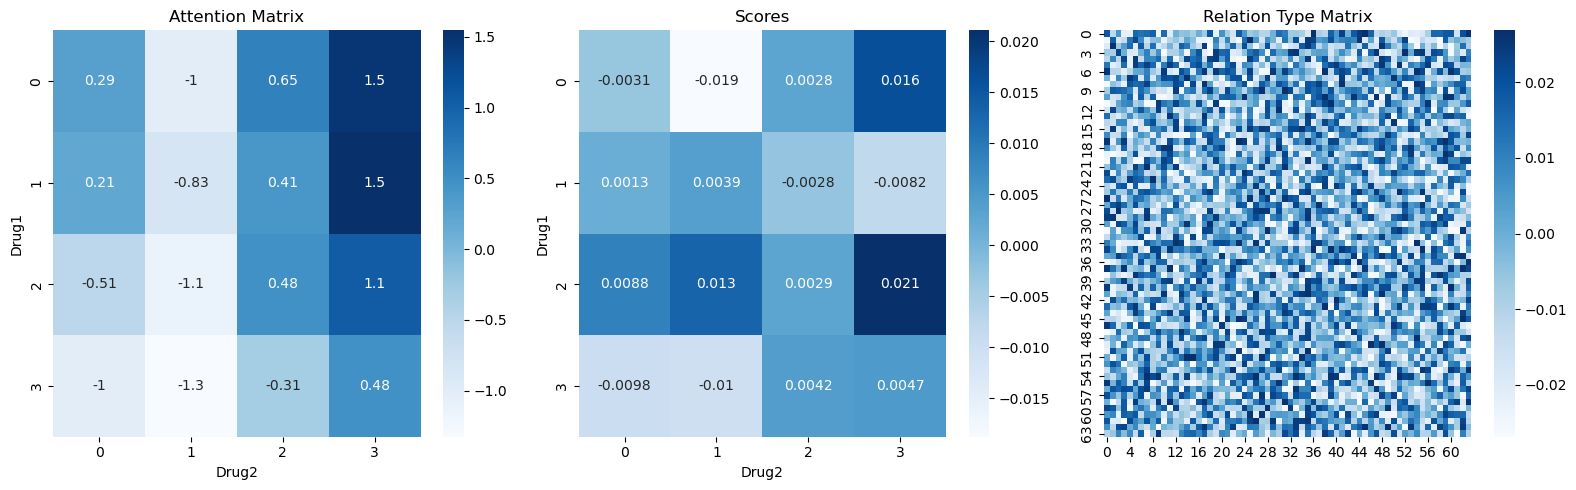

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5)) 

sns.heatmap(attention_matrix[0], cmap="Blues", annot=True, ax=axes[0])
axes[0].set_title('Attention Matrix')
axes[0].set_xlabel('Drug2')
axes[0].set_ylabel('Drug1')

sns.heatmap(original_scores[0], cmap="Blues", annot=True, ax=axes[1])
axes[1].set_title('Scores')
axes[1].set_xlabel('Drug2')
axes[1].set_ylabel('Drug1')

sns.heatmap(rels[0], cmap="Blues", annot=False, ax=axes[2])
axes[2].set_title('Relation Type Matrix')

plt.tight_layout()
plt.show()

1. Co-attention으로 생성된 `Attention Matrix`를 살펴보자.    
이는 두 약물의 4가지 GNN layer에서의 상호작용 중요도를 나타내는 가중치 값이다.    

2. `Score Matrix`는 우선 두 약물과 relation type을 사용하여 계산된다.    
이후 Attention Matrix를 곱하여 layer간 중요도를 반영한다.   
이 4*4의 score matrix를 sum하여 나온 결과값을 최종 score로 사용하고, postive쌍이면 1에 가깝게, negative쌍이면 0에 가깝게 예측되도록 학습한다.    

3. `Relation type Matrix`를 살펴보자.   
숫자 1개로 나오는 relation type이 64*64 형태로 표현되어 처리된다. 

## 3) 모델 학습 실행하기

하나의 배치 안에는 Positive Sample쌍과 Negative Sample쌍이 동시에 들어있다. 

그리고 하나의 Positive/Negative Sample쌍에는 (head, tail, relation type)이 들어있다. 

do_compute 함수에서는 positive sample쌍과 negative sample쌍을 따로 처리하여 model에 입력하고, 

p_score과 n_score를 따로 뽑아 loss를 계산한다. 

In [32]:
def do_compute(batch, device, training=True):
        '''
            *batch: (pos_tri, neg_tri) 
            *pos/neg_tri: (batch_h, batch_t, batch_r)
        '''
        probas_pred, ground_truth = [], []
        pos_tri, neg_tri = batch
        
        pos_tri = [tensor.to(device=device) for tensor in pos_tri]
        p_score = model(pos_tri)
        probas_pred.append(torch.sigmoid(p_score.detach()).cpu()) # positive sample쌍으로 모델이 예측한 값
        ground_truth.append(np.ones(len(p_score))) # positive sample쌍의 정답 label은 1

        neg_tri = [tensor.to(device=device) for tensor in neg_tri]
        n_score = model(neg_tri)
        probas_pred.append(torch.sigmoid(n_score.detach()).cpu()) # negative sample쌍으로 모델이 예측한 값
        ground_truth.append(np.zeros(len(n_score))) # negative sample쌍의 정답 label은 0

        probas_pred = np.concatenate(probas_pred) # 예측값끼리 concatenate
        ground_truth = np.concatenate(ground_truth) # 정답 label끼리 concatenate

        return p_score, n_score, probas_pred, ground_truth

In [33]:
def do_compute_metrics(probas_pred, target): # 예측값과 정답 label을 이용하여 성능 측정
    pred = (probas_pred >= 0.5).astype(int)

    acc = metrics.accuracy_score(target, pred)
    auc_roc = metrics.roc_auc_score(target, probas_pred)
    f1 = metrics.f1_score(target, pred)

    precision = metrics.precision_score(target, pred)
    recall = metrics.recall_score(target, pred)
    p, r, _ = metrics.precision_recall_curve(target, probas_pred)
    auc_prc = metrics.auc(r, p)

    return acc, auc_roc, precision, recall, f1, auc_prc


학습할 모델을 정의하였다. 

In [34]:
model = SSI_DDI(n_atom_feats, n_atom_hid, kge_dim, rel_total, heads_out_feat_params=[32, 32, 32, 32], blocks_params=[2, 2, 2, 2])
model

SSI_DDI(
  (initial_norm): LayerNorm(55, affine=True, mode=graph)
  (net_norms): ModuleList(
    (0-3): 4 x LayerNorm(64, affine=True, mode=graph)
  )
  (block0): SSI_DDI_Block(
    (conv): GATConv(55, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block1): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block2): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block3): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (co_attention): CoAttentionLayer()
  (KGE): RESCAL(87, torch.Size([87, 4096]))
)

모델의 loss는 다음과 같이 사용한다. 

- p_loss : positive sample의 점수   
- n_loss : negative sample의 점수

F.logsigmoid().mean() 계산을 통해 p_loss는 더 높게, n_loss는 더 낮게 예측하도록 손실값을 조정한다. 

In [35]:
class SigmoidLoss(nn.Module):
    def __init__(self, adv_temperature=None):
        super().__init__()
        self.adv_temperature = adv_temperature
    
    def forward(self, p_scores, n_scores):
        if self.adv_temperature:
            weights= F.softmax(self.adv_temperature * n_scores, dim=-1).detach()
            n_scores = weights * n_scores
        p_loss = - F.logsigmoid(p_scores).mean()
        n_loss = - F.logsigmoid(-n_scores).mean()
        
        return (p_loss + n_loss) / 2, p_loss, n_loss 

In [36]:
loss = SigmoidLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.96 ** (epoch))

In [37]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

학습과 검증은 다음 train 함수에 의해 이루어진다. 

전처리된 train_data_loader, valid_data_loader를 사용하여 데이터를 배치 단위로 처리한다.    

(1) `Train 단계` (모델을 train 모드로 설정)

- 예측 점수(p_score, n_score)와 확률(probas_pred)을 계산
- 손실 함수(loss_fn)로 손실(loss, loss_p, loss_n)을 계산
- 역전파 및 최적화(optimizer)를 수행하여 모델 파라미터를 업데이트
- 각 배치의 손실을 합산하여 총 훈련 손실을 계산

(2) `Validation 단계` (모델을 eval 모드로 설정)

- 손실과 예측 점수를 계산하여 검증 손실 및 성능 지표(AUC-ROC, AUC-PRC 등)를 평가

(3) `metrics 계산`

- Train과 Validation 단계에서 수집된 **예측 확률(probas_pred)**과 **정답(ground_truth)**을 사용해 다음 성능 지표를 계산:
    - Accuracy: 올바른 예측 비율.
    - AUC-ROC: 양성과 음성을 구분하는 능력.
    - AUC-PRC: Precision-Recall 커브의 면적.
    - Precision, Recall, F1-Score: 모델의 정밀도와 재현율.

(4) `Best 모델 저장`

- 각 에폭이 끝날 때, val_loss가 현재까지의 최저값보다 낮으면 best_model.pth에 모델의 상태를 저장   

(5) `결과 출력`

- 에포크마다 손실 및 성능 지표를 출력하여 모델 학습 상태를 확인

In [38]:
def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, n_epochs, device, scheduler=None):
    print('Starting training at', datetime.today())
    best_val_loss = float('inf')
    best_model_state = None

    for i in range(1, n_epochs + 1):
        start = time.time()
        train_loss = 0
        val_loss = 0
        train_probas_pred = []
        train_ground_truth = []
        val_probas_pred = []
        val_ground_truth = []

        #### Train 과정 ######################################################################
        for batch in train_data_loader:
            model.train()
            p_score, n_score, probas_pred, ground_truth = do_compute(batch, device)
            train_probas_pred.append(probas_pred)
            train_ground_truth.append(ground_truth)
            loss, _, _ = loss_fn(p_score, n_score)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(p_score)
        train_loss /= len(train_data_loader.dataset)
        ######################################################################################

        #### Validation 과정 ##################################################################
        with torch.no_grad():
            train_probas_pred = np.concatenate(train_probas_pred)
            train_ground_truth = np.concatenate(train_ground_truth)
            train_acc, train_auc_roc, train_precision, train_recall, train_f1, train_auc_prc = do_compute_metrics(train_probas_pred, train_ground_truth)

            for batch in val_data_loader:
                model.eval()
                p_score, n_score, probas_pred, ground_truth = do_compute(batch, device)
                val_probas_pred.append(probas_pred)
                val_ground_truth.append(ground_truth)
                loss, _, _ = loss_fn(p_score, n_score)
                val_loss += loss.item() * len(p_score)

            val_loss /= len(val_data_loader.dataset)
            val_probas_pred = np.concatenate(val_probas_pred)
            val_ground_truth = np.concatenate(val_ground_truth)
            val_acc, val_auc_roc, val_precision, val_recall, val_f1, val_auc_prc = do_compute_metrics(val_probas_pred, val_ground_truth)
        ######################################################################################

        #### Best 모델 저장 ####################################################################
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            torch.save({k: v.cpu() for k, v in best_model_state.items()}, "best_model.pth")
        ######################################################################################

        #### 학습률 조정 ######################################################################
        if scheduler:
            scheduler.step()
        ######################################################################################

        print(f'Epoch: {i}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_acc:.4f}, Validation AUC: {val_auc_roc:.4f}, '
              f'Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, '
              f'Validation F1-score: {val_f1:.4f}, Validation AUPR: {val_auc_prc:.4f}')

    # Best 모델 로드
    model.load_state_dict(torch.load("best_model.pth", map_location='cuda:0' if torch.cuda.is_available() else 'cpu'))

    return model

다음 코드를 실행하면 모델이 동작하는 것을 확인할 수 있다. 

In [39]:
model.to(device=device);

In [41]:
train(model, train_data_loader, valid_data_loader, loss, optimizer, n_epochs, device, scheduler)

Starting training at 2024-12-29 20:21:08.777835
Epoch: 1, train_loss: 0.6807, val_loss: 0.6936, Validation Accuracy: 0.5160, Validation AUC: 0.5275, Validation Precision: 0.5187, Validation Recall: 0.4446, Validation F1-score: 0.4788, Validation AUPR: 0.5265
Epoch: 2, train_loss: 0.6677, val_loss: 0.7008, Validation Accuracy: 0.5167, Validation AUC: 0.5282, Validation Precision: 0.5181, Validation Recall: 0.4789, Validation F1-score: 0.4977, Validation AUPR: 0.5223
Epoch: 3, train_loss: 0.6763, val_loss: 0.7013, Validation Accuracy: 0.5063, Validation AUC: 0.5031, Validation Precision: 0.5059, Validation Recall: 0.5409, Validation F1-score: 0.5228, Validation AUPR: 0.4980
Epoch: 4, train_loss: 0.6653, val_loss: 0.7441, Validation Accuracy: 0.5112, Validation AUC: 0.5108, Validation Precision: 0.5191, Validation Recall: 0.3051, Validation F1-score: 0.3843, Validation AUPR: 0.5186
Epoch: 5, train_loss: 0.6847, val_loss: 0.6923, Validation Accuracy: 0.5190, Validation AUC: 0.5317, Validat

SSI_DDI(
  (initial_norm): LayerNorm(55, affine=True, mode=graph)
  (net_norms): ModuleList(
    (0-3): 4 x LayerNorm(64, affine=True, mode=graph)
  )
  (block0): SSI_DDI_Block(
    (conv): GATConv(55, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block1): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block2): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (block3): SSI_DDI_Block(
    (conv): GATConv(64, 32, heads=2)
    (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
  )
  (co_attention): CoAttentionLayer()
  (KGE): RESCAL(87, torch.Size([87, 4096]))
)

## 4) 모델 Test하고 성능 저장하기

Train과 Validation 후 저장된 최적의 모델(best_model.pth)를 불러와 테스트 데이터(test_data_loader)에 대해 최종 성능을 평가하고, 그 결과를 CSV 파일로 저장하는 과정이다.  

모델 성능 평가를 위한 최종 단계로, Test 데이터를 기반으로 손실과 다양한 성능 지표를 계산할 수 있다.    

아래 코드는 torch.load를 사용하여 저장된 최적의 모델의 가중치를 로드하고, 이 모델로 test를 진행한 후 tabulate와 pandas를 활용해 표 형식으로 출력하게 한다.     
또한 성능 지표를 pandas.DataFrame으로 변환한 후 CSV 파일로 저장하게 한다.    

In [42]:
def test_and_save(model, test_data_loader, loss_fn, device, best_model_path="best_model.pth", csv_file="best_model_results.csv"):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.to(device)
    model.eval()

    test_loss = 0
    test_probas_pred = []
    test_ground_truth = []

    with torch.no_grad():
        for batch in test_data_loader:
            p_score, n_score, probas_pred, ground_truth = do_compute(batch, device)
            test_probas_pred.append(probas_pred)
            test_ground_truth.append(ground_truth)
            loss, _, _ = loss_fn(p_score, n_score)
            test_loss += loss.item() * len(p_score)

    test_loss /= len(test_data_loader.dataset)
    test_probas_pred = np.concatenate(test_probas_pred)
    test_ground_truth = np.concatenate(test_ground_truth)

    test_acc, test_auc_roc, test_precision, test_recall, test_f1, test_auc_prc = do_compute_metrics(test_probas_pred, test_ground_truth)

    metrics = {
        "Loss": test_loss,
        "Accuracy": test_acc,
        "AUC_ROC": test_auc_roc,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1-Score": test_f1,
        "AUC_PRC": test_auc_prc
    }

    print("\n최적 모델의 테스트 데이터 성능:")
    print(tabulate(pd.DataFrame(metrics, index=["Metric Value"]).T, headers="keys", tablefmt="fancy_grid"))

    df = pd.DataFrame(metrics, index=[0])
    df.to_csv(csv_file, index=False)
    print(f"\nResults saved to {csv_file}")

    return metrics


In [43]:
best_metrics = test_and_save(model, test_data_loader, loss, device)


최적 모델의 테스트 데이터 성능:
╒═══════════╤════════════════╕
│           │   Metric Value │
╞═══════════╪════════════════╡
│ Loss      │       0.468922 │
├───────────┼────────────────┤
│ Accuracy  │       0.776537 │
├───────────┼────────────────┤
│ AUC_ROC   │       0.856697 │
├───────────┼────────────────┤
│ Precision │       0.772257 │
├───────────┼────────────────┤
│ Recall    │       0.784396 │
├───────────┼────────────────┤
│ F1-Score  │       0.778279 │
├───────────┼────────────────┤
│ AUC_PRC   │       0.836649 │
╘═══════════╧════════════════╛

Results saved to best_model_results.csv
